In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf
import seaborn as sn
from random import shuffle
import statistics
import csv
import pandas as pd

from tensorflow.keras.layers import Input, Lambda, Concatenate, Dense, Flatten, Conv2D, Conv3D, Conv1D, AveragePooling2D, AveragePooling3D, AveragePooling1D, BatchNormalization, Dropout,MaxPooling3D, MaxPooling2D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import CSVLogger

import numpy as np
from glob import glob
from tensorflow.keras.layers import MaxPooling2D

from matplotlib import pyplot

# ESN implementation

In [2]:
class ESN:
    def __init__(self, N_inputs, N_reservoir = 50, spectral_radius = 1, sparsity = 0, noise = 0.001, random_state = None):
        
        self.N_inputs = N_inputs
        self.N_reservoir = N_reservoir
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.random_state = random_state

        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand
        self.initweights()
        
        
    def initweights(self):
        W = self.random_state_.rand(self.N_reservoir, self.N_reservoir) - 0.5
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / radius)
        self.W_in = self.random_state_.rand(
                    self.N_reservoir, self.N_inputs) * 2 - 1
       
    def _update(self, state, input_pattern):
        preactivation = (np.dot(self.W, state)+ np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)+ self.noise * (self.random_state_.rand(self.N_reservoir) - 0.5))
        
    def fit_internal_state(self, inputs, inspect=False):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))

        states = np.zeros((inputs.shape[0], self.N_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs[n, :])
            
        extended_states = np.hstack((states, inputs))

        if inspect:
            from matplotlib import pyplot as plt
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',interpolation='nearest')
            plt.colorbar()
            print(states.shape)
        
        return states

 ## Open dataset file

In [9]:
file_name = "/home/user/Scrivania/Dottorato/Time_Series_Classification/ECG200/ECG200/ECG200_TRAIN.txt"
data_train = pd.read_csv(file_name, sep='  ', header=None, engine='python').T

In [10]:
file_name = "/home/user/Scrivania/Dottorato/Time_Series_Classification/ECG200/ECG200/ECG200_TEST.txt"
data_test = pd.read_csv(file_name, sep='  ', header=None, engine='python').T

In [11]:
vec_ECG200_input_TRAIN = []
vec_ECG200_output_TRAIN = []

vec_ECG200_input_TEST = []
vec_ECG200_output_TEST = []

for f in range(100):
    vec_ECG200_input_TRAIN.append(data_train[f].values)
    vec_ECG200_input_TEST.append(data_test[f].values)

## Shuffle dataset

In [12]:
random.shuffle(vec_ECG200_input_TRAIN)
random.shuffle(vec_ECG200_input_TEST)

In [13]:
for f in range(100):
    vec_ECG200_output_TRAIN.append(vec_ECG200_input_TRAIN[f][0])
    vec_ECG200_input_TRAIN[f] = np.delete(vec_ECG200_input_TRAIN[f], 0)
    vec_ECG200_output_TEST.append(vec_ECG200_input_TEST[f][0])
    vec_ECG200_input_TEST[f] = np.delete(vec_ECG200_input_TEST[f], 0)

## Generate output classes

In [14]:
vec_output_Class_TRAIN = []
vec_output_Class_TEST = []

count = 0

for i in range(100):
        
    if vec_ECG200_output_TRAIN[i] == -1.0:
        array = np.array([1,0])
        vec_output_Class_TRAIN.append(array)
    elif vec_ECG200_output_TRAIN[i] == 1.0:
        array = np.array([0,1])
        vec_output_Class_TRAIN.append(array)   
        
    if vec_ECG200_output_TEST[i] == -1.0:
        array = np.array([1,0])
        vec_output_Class_TEST.append(array)
    elif vec_ECG200_output_TEST[i] == 1.0:   
        array = np.array([0,1])
        vec_output_Class_TEST.append(array)

## Time Series Standardization

In [16]:
vec_ECG200_input_TRAIN_standardize = []
vec_ECG200_input_TEST_standardize = []

for j in range(100):
    mean_X = np.mean(vec_ECG200_input_TRAIN[j])
    std_dev_X = np.std(vec_ECG200_input_TRAIN[j])
    
    vec_ECG200_input_TRAIN_standardize.append((vec_ECG200_input_TRAIN[j]-mean_X)/std_dev_X)
    
    mean_X = np.mean(vec_ECG200_input_TEST[j])
    std_dev_X = np.std(vec_ECG200_input_TEST[j])
    
    vec_ECG200_input_TEST_standardize.append((vec_ECG200_input_TEST[j]-mean_X)/std_dev_X)

# ESN layer 

In [20]:
N_inputs = 1
N_reservoir = 50
vec_internal_states_ECG200_TRAIN = []
vec_internal_states_ECG200_TEST = []

for i in range(100):
    
    input_ESN_TRAIN = vec_ECG200_input_TRAIN_standardize[i]
    input_ESN_TEST = vec_ECG200_input_TEST_standardize[i]

    esn_train = ESN(N_inputs = 1,
                  N_reservoir = N_reservoir,
                  noise=0.01,
                  spectral_radius = 0.94,
                  random_state=40)
    
    internal_states_TRAIN = esn_train.fit_internal_state(input_ESN_TRAIN)
    vec_internal_states_ECG200_TRAIN.append(internal_states_TRAIN)
    esn_test = ESN(N_inputs = 1,
                  N_reservoir = N_reservoir,
                  noise=0.01,
                  spectral_radius = 0.94,
                  random_state=40)
    
    internal_states_TEST = esn_train.fit_internal_state(input_ESN_TEST)
    vec_internal_states_ECG200_TEST.append(internal_states_TEST)

## Plot reservoir internal states

<IPython.core.display.Javascript object>


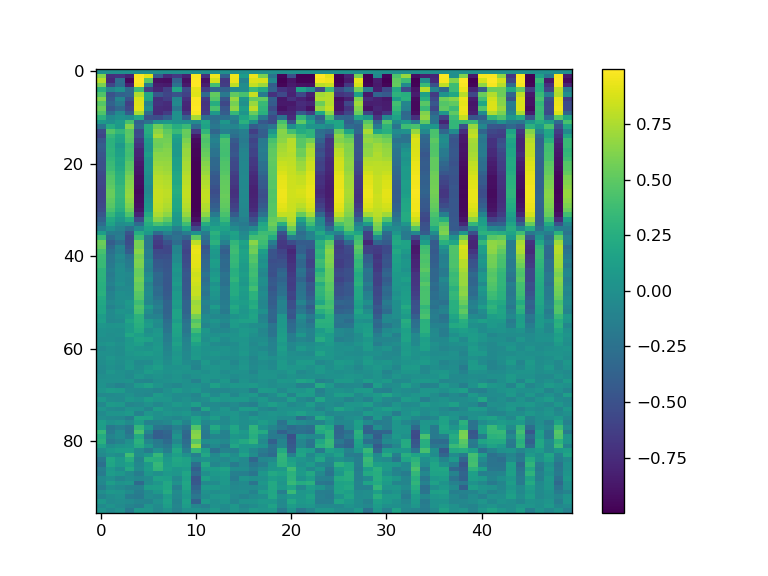

In [21]:
%matplotlib notebook
plt.imshow(vec_internal_states_ECG200_TRAIN[71], aspect="auto")
plt.colorbar()
plt.show()

# Convolutional/Flattening/Fully Connected layer

In [22]:
trainlen = 70
testlen = 30

X_train = np.array(vec_internal_states_ECG200_TRAIN[0:trainlen])
Y_train = np.array(vec_output_Class_TRAIN[0:trainlen])
X_train = tf.stack(X_train)
Y_train = tf.stack(Y_train)

X_train = tf.expand_dims(X_train, axis=-1)

X_test = np.array(vec_internal_states_ECG200_TRAIN[trainlen:trainlen+testlen])
Y_test = np.array(vec_output_Class_TRAIN[trainlen:trainlen+testlen])

X_test = tf.expand_dims(X_test, axis=-1)

model=Sequential()
model.add(Conv2D(filters=32,kernel_size=5,padding="same",activation="relu",input_shape=(96,N_reservoir,1), kernel_regularizer=regularizers.l2(l=0.01)))
model.add(AveragePooling2D(pool_size=5))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu", kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=3))
model.add(Flatten())
model.add(Dense(80,activation="relu"))
model.add(Dense(20,activation="relu"))
model.add(Dense(2,activation="softmax"))


opt = SGD(lr=0.01)
opt_adam = 'adam'
opt_adamax = "Adamax"
#opt_Adam = Adam(learning_rate=0.001)

binary_crossentropy = 'binary_crossentropy'
categorical_crossentropy = 'categorical_crossentropy'

model.compile(loss=binary_crossentropy,optimizer=opt_adam,metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 50, 32)        832       
_________________________________________________________________
average_pooling2d (AveragePo (None, 19, 10, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 10, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 10, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 80)                9

2022-09-14 11:50:22.064545: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-14 11:50:22.068688: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 11:50:22.074604: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [23]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100)

2022-09-14 11:50:38.641197: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-14 11:50:38.664319: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/100
3/3 [==============================] - 2s 398ms/step - loss: 1.1554 - accuracy: 0.7100 - val_loss: 1.1231 - val_accuracy: 0.7000
Epoch 2/100
3/3 [==============================] - 1s 257ms/step - loss: 1.0453 - accuracy: 0.6814 - val_loss: 1.1231 - val_accuracy: 0.7000
Epoch 3/100
3/3 [==============================] - 1s 309ms/step - loss: 0.9682 - accuracy: 0.7503 - val_loss: 1.1110 - val_accuracy: 0.7667
Epoch 4/100
3/3 [==============================] - 1s 276ms/step - loss: 0.9265 - accuracy: 0.7308 - val_loss: 1.1023 - val_accuracy: 0.7667
Epoch 5/100
3/3 [==============================] - 1s 236ms/step - loss: 0.8720 - accuracy: 0.7614 - val_loss: 1.0896 - val_accuracy: 0.7667
Epoch 6/100
3/3 [==============================] - 1s 235ms/step - loss: 0.8243 - accuracy: 0.7920 - val_loss: 1.0848 - val_accuracy: 0.7667
Epoch 7/100
3/3 [==============================] - 1s 249ms/step - loss: 0.8381 - accuracy: 0.7860 - val_loss: 1.0763 - val_accuracy: 0.7000
Epoch 8/100
3

<IPython.core.display.Javascript object>


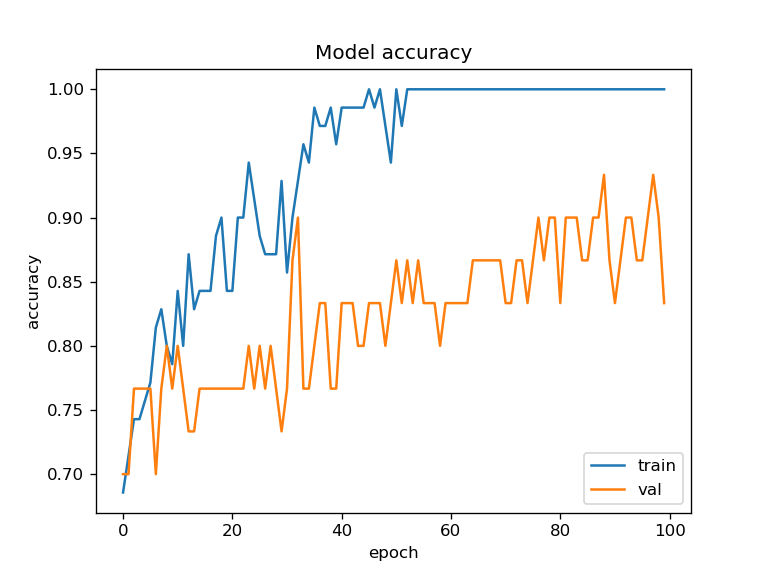

In [24]:
%matplotlib notebook
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


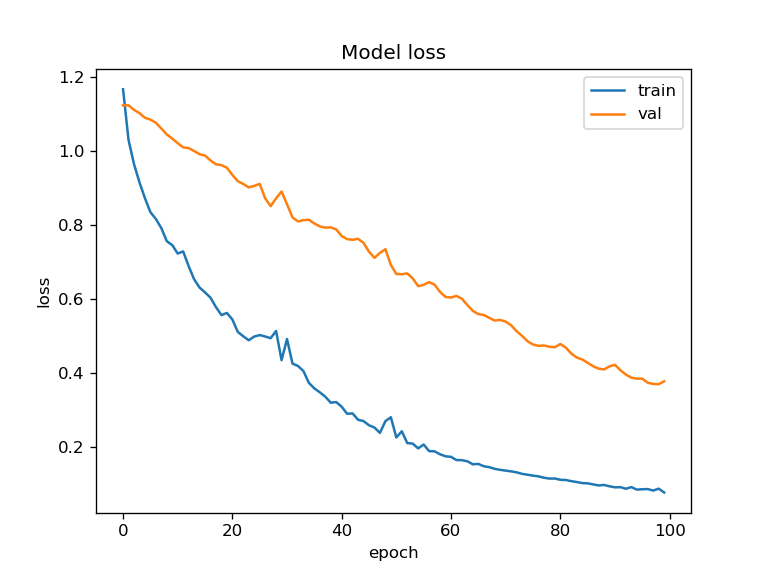

In [25]:
%matplotlib notebook
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Model prediction 

In [26]:
X_test = np.array(vec_internal_states_ECG200_TEST)
Y_test = np.array(vec_output_Class_TEST)
X_test = tf.expand_dims(X_test, axis=-1)

prediction = model.predict(X_test)


In [27]:
test_preds = np.where(prediction > 0.5, 1, 0)
test_accuracy = accuracy_score(Y_test, test_preds)
test_accuracy

0.88

In [28]:
y_pred_bool = np.argmax(prediction, axis=1)
test_accuracy = accuracy_score(vec_ECG200_output_TEST, 2*y_pred_bool-1)
test_accuracy

0.88

## Plot confusion matrix 

<IPython.core.display.Javascript object>


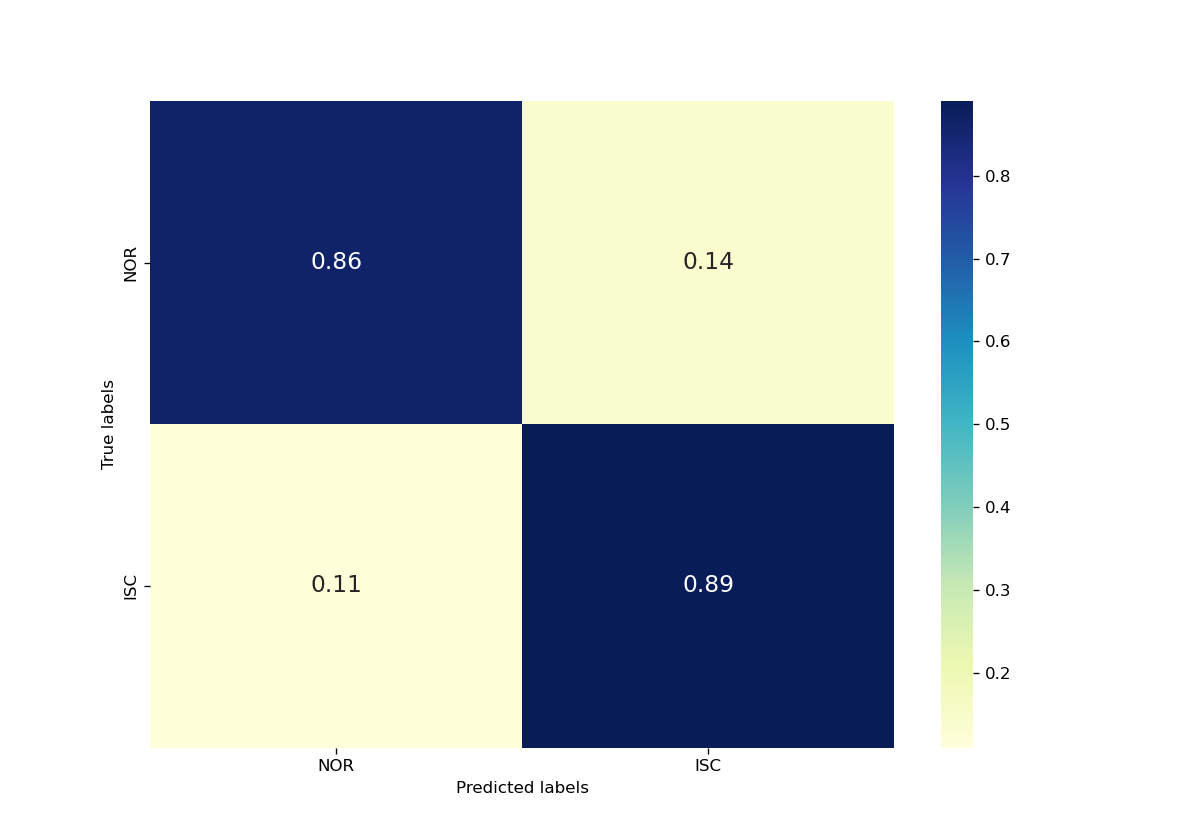

Sensitivity is :
0.890625
Specificity is :
0.8611111111111112
Accuracy is:
0.88
F1-score is:
0.9047619047619048


In [29]:
%matplotlib notebook
count_correct_FIRST = 0 #TP
count_correct_SECOND = 0 #TN
count_errate_FIRST = 0 #FN
count_errate_SECOND = 0 #FP

count_FIRST = 0
count_SECOND = 0

for k in range(100):
    if vec_output_Class_TEST[k][0] == 0:
        count_FIRST = count_FIRST + 1
        if vec_output_Class_TEST[k][0] == test_preds[k][0]:
            count_correct_FIRST = count_correct_FIRST + 1
        else:
            count_errate_FIRST = count_errate_FIRST + 1
    if vec_output_Class_TEST[k][0] == 1:
        count_SECOND = count_SECOND + 1
        if vec_output_Class_TEST[k][0] == test_preds[k][0]:
            count_correct_SECOND = count_correct_SECOND + 1
        else:
            count_errate_SECOND = count_errate_SECOND + 1

array = [[count_correct_SECOND/count_SECOND,count_errate_SECOND/count_SECOND],[count_errate_FIRST/count_FIRST,count_correct_FIRST/count_FIRST]]          
df_cm = pd.DataFrame(array, index = ["NOR","ISC"],
                  columns = ["NOR","ISC"])
plt.figure(figsize = (10,7))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax = sn.heatmap(df_cm, annot=True, cmap="YlGnBu", annot_kws={'fontsize':14})

ax.set(xlabel='Predicted labels', ylabel='True labels')

plt.show()

plt.savefig('confusion_mat_ECG200.png')

TP = count_correct_FIRST
TN = count_correct_SECOND
FN = count_errate_FIRST
FP = count_errate_SECOND

sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)

accuracy = (TP+TN)/(TP+TN+FP+FN)
f1_score = (2*TP)/(2*TP+FP+FN)

print("Sensitivity is :")
print(sensitivity)
print("Specificity is :")
print(specificity)
print("Accuracy is:")
print(accuracy)
print("F1-score is:")
print(f1_score)